In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2.3.0
2.4.0


In [2]:
BASE_DIR = "./data/utk_dataset/processed"

In [3]:
# labels: age, gender, ethnicity (NOT NEEDED)
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [4]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./data/utk_dataset/processed\100_0_0_201701122...,100,0
1,./data/utk_dataset/processed\100_0_0_201701122...,100,0
2,./data/utk_dataset/processed\100_1_0_201701101...,100,1
3,./data/utk_dataset/processed\100_1_0_201701122...,100,1
4,./data/utk_dataset/processed\100_1_0_201701122...,100,1


In [5]:
# map labels for gender 
gender_dict = {0:'Male', 1:'Female'}

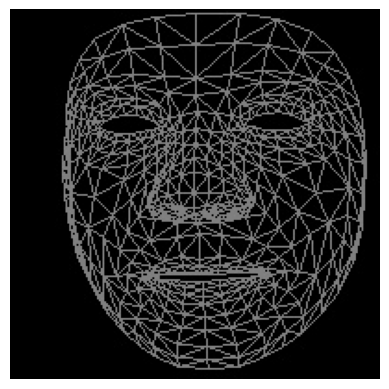

In [6]:
from PIL import Image 
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

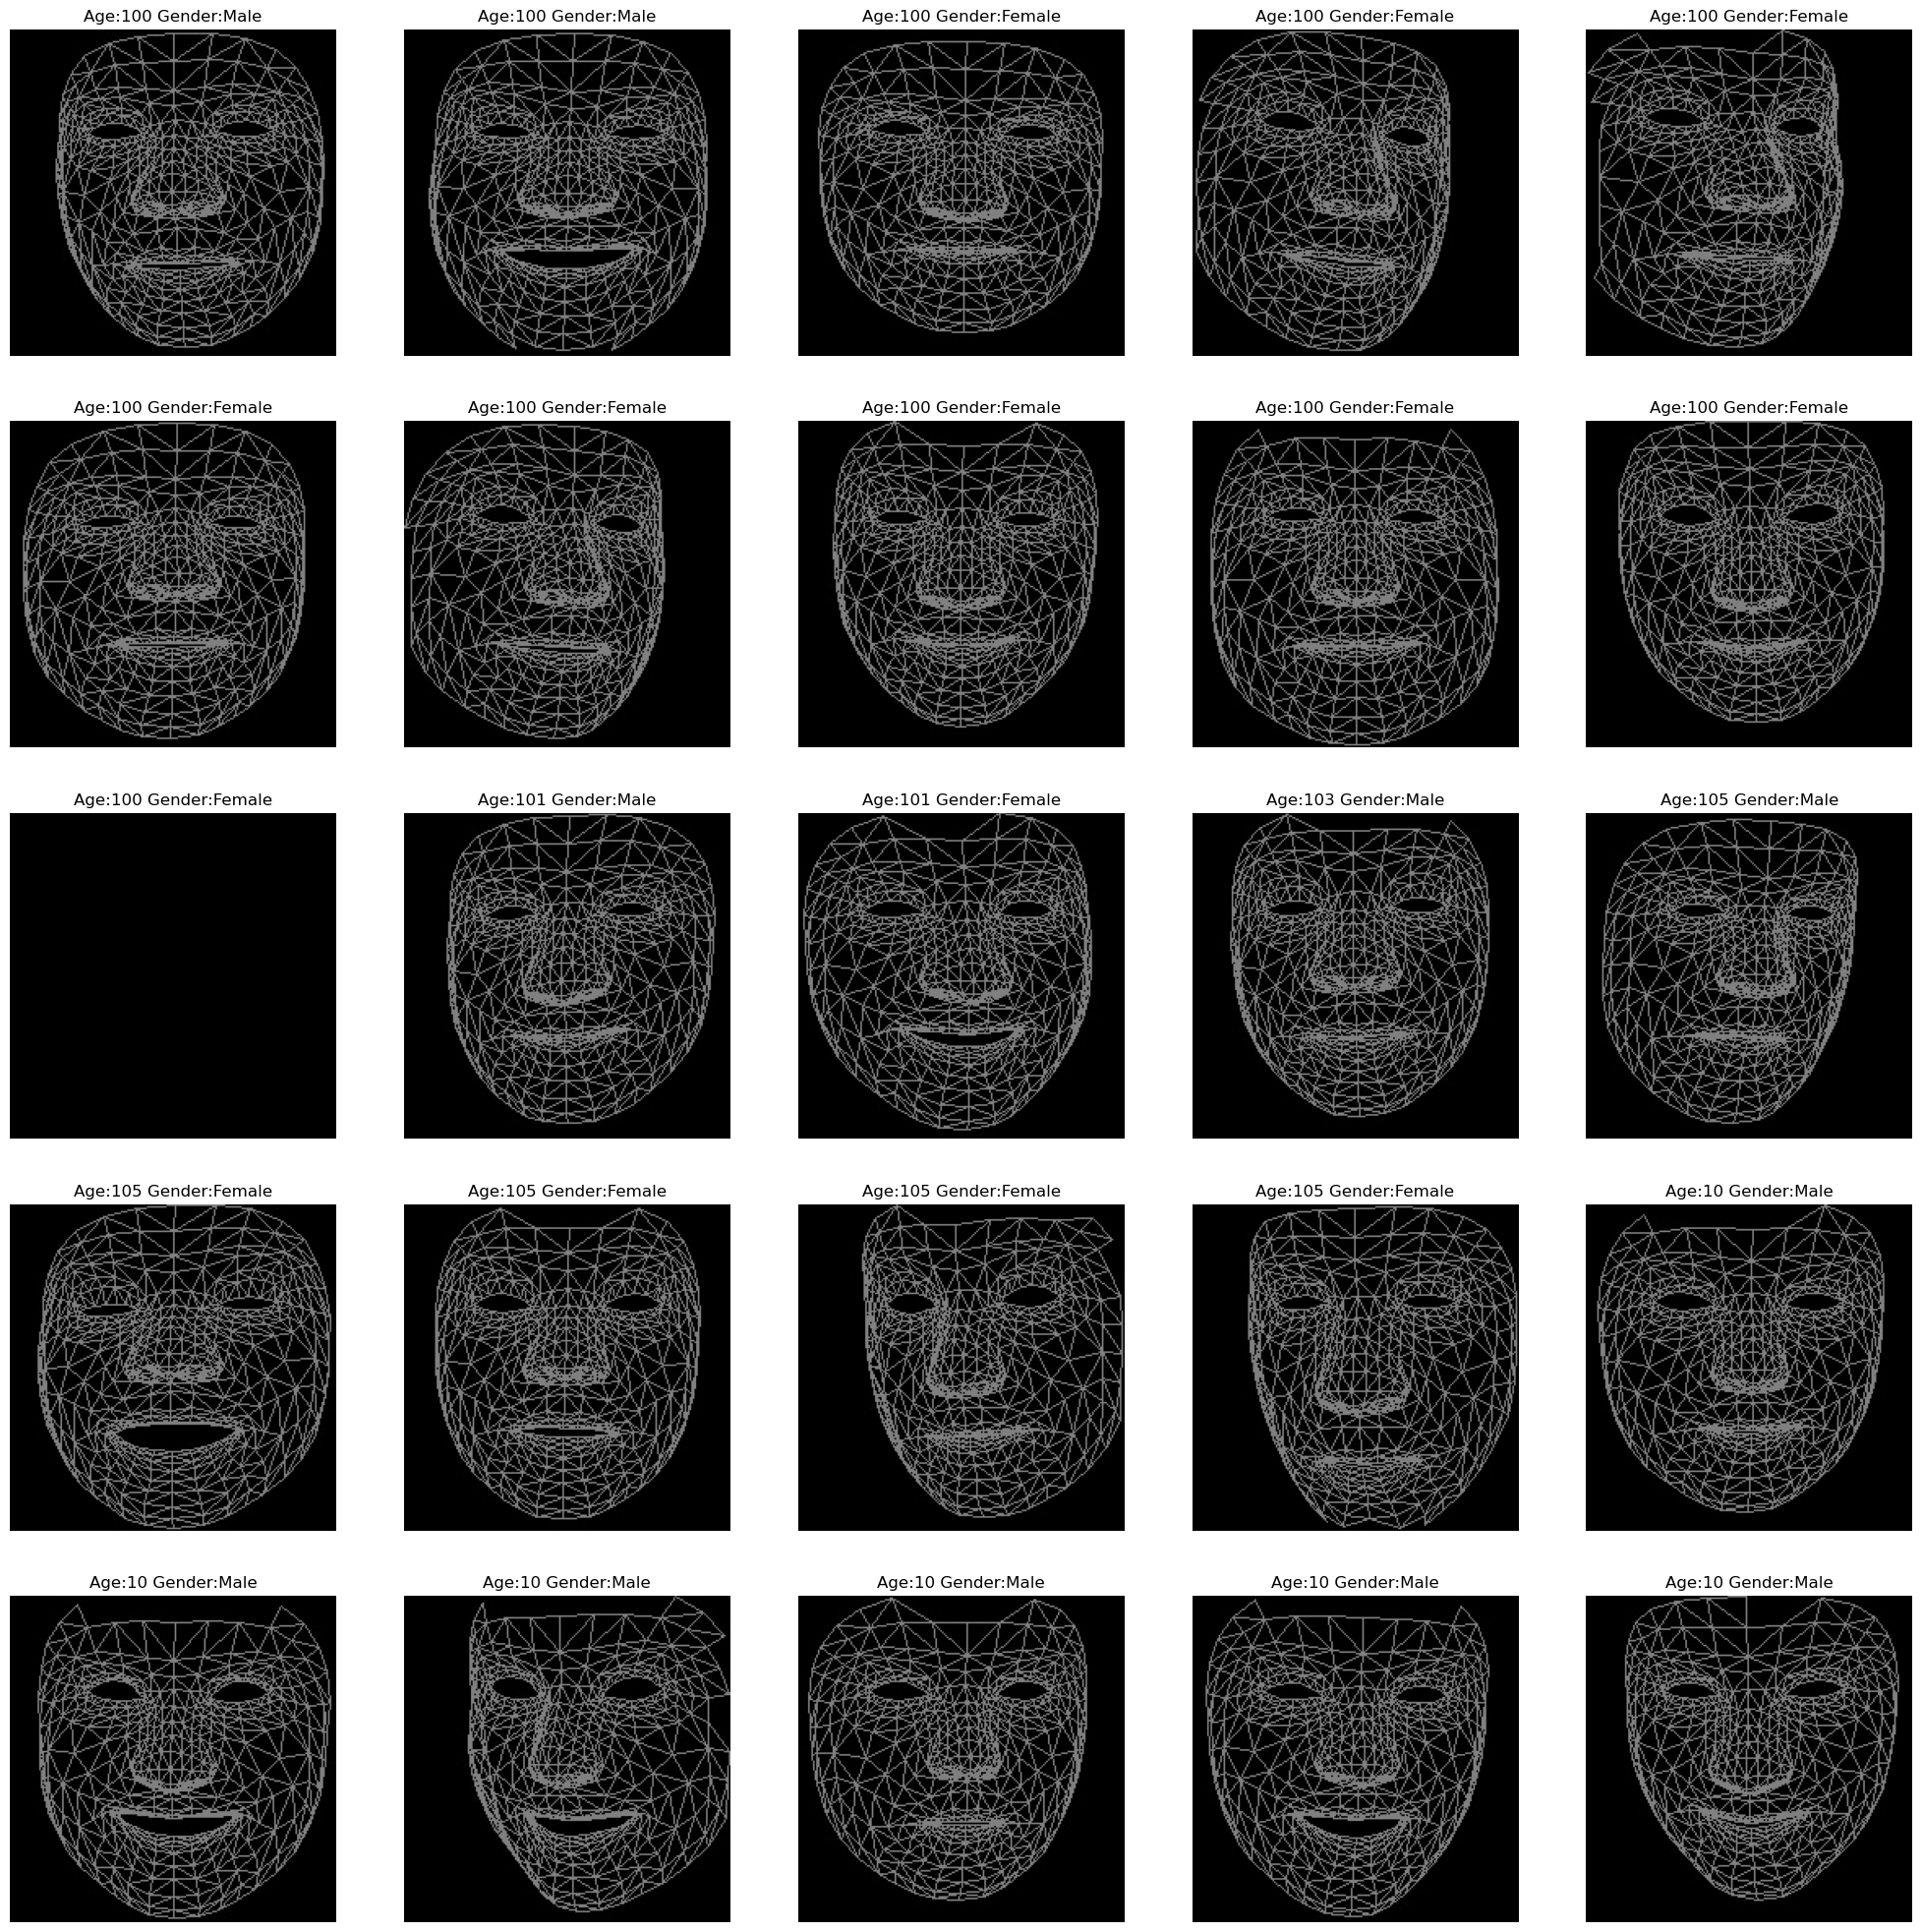

In [7]:
plt.figure(figsize = (25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = tf.keras.preprocessing.image.load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis("off")

In [8]:
## Feature Extraction
def extract_features(images):
    features = []
    for image in images: 
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [9]:
X = extract_features(df['image'])

In [10]:
X.shape

(23708, 128, 128, 1)

In [11]:
# Normailise images
X = X/255.0

In [12]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [13]:
input_shape = (128, 128, 1)

### Model Creation

In [59]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [60]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 125s 210ms/step - loss: 11.1314 - gender_out_loss: 0.7057 - age_out_loss: 10.4258 - gender_out_accuracy: 0.5149 - age_out_accuracy: 0.0589 - val_loss: 35.6332 - val_gender_out_loss: 0.6916 - val_age_out_loss: 34.9416 - val_gender_out_accuracy: 0.5344 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
593/593 [==============================] - 129s 217ms/step - loss: 9.4385 - gender_out_loss: 0.6379 - age_out_loss: 8.8006 - gender_out_accuracy: 0.6351 - age_out_accuracy: 0.0546 - val_loss: 31.7073 - val_gender_out_loss: 0.6000 - val_age_out_loss: 31.1072 - val_gender_out_accuracy: 0.6795 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
593/593 [==============================] - 131s 221ms/step - loss: 8.3936 - gender_out_loss: 0.5542 - age_out_loss: 7.8395 - gender_out_accuracy: 0.7228 - age_out_accuracy: 0.0411 - val_loss: 30.9839 - val_gender_out_loss: 0.5654 - val_age_out_loss: 30.4184 - val_gender_out_accuracy: 0.7199 - val_age_out_accur

## Plotting of Results

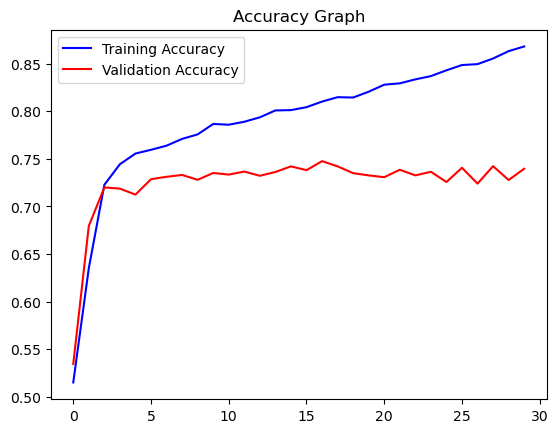

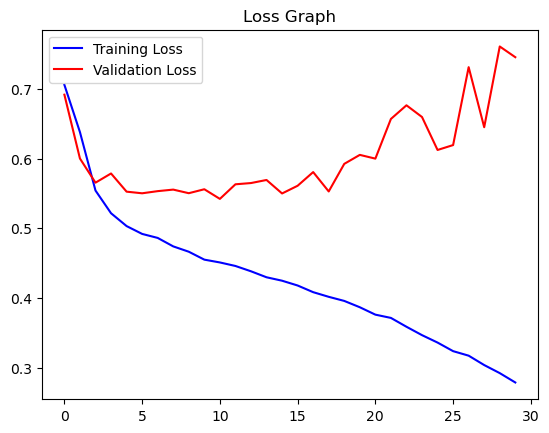

In [61]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

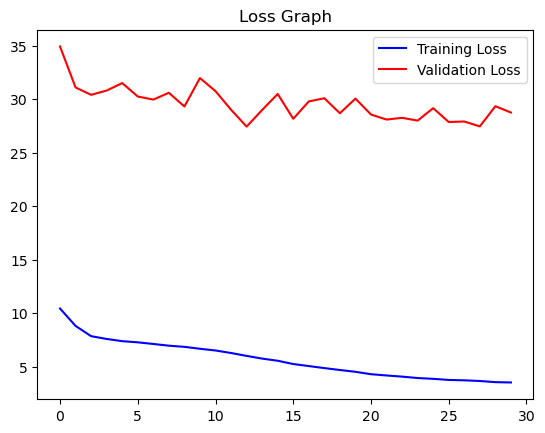

In [62]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()